# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/Home/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'training data size:', len(train_data)
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names


training label shape: (2034,)
training data size: 2034
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def P1(num_examples=10):
### STUDENT START ###
    print("For each of the first 5 training examples, the text of the message along with the label: \n")
# Loop through training documents and print supplied number of documents
    for i in range(num_examples):
        print("\nTraining example %d text \n  %s \n " % (i+1, train_data[i]))
        print("Training example %d label: %s \n\n " % (i+1, train_labels[i]))
        print("####################################################################################")

### STUDENT END ###
P1(5)
#[0] --> alt.atheism
#[1] -->comp.graphics
#[2] -->sci.space
#[3] --> talk.religion.misc

For each of the first 5 training examples, the text of the message along with the label: 


Training example 1 text 
  Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 
 
Training example 1 label: 1 

 
####################################################################################

Training example 2 text 
  

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary t

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
def P2():
### STUDENT START ###
# Initialize CountVectorizer with default parameters
    vectorizer_train = CountVectorizer(min_df=1)
# Call fit_transform method on train data
    X_train_data = vectorizer_train.fit_transform(train_data)
#a.
    print("\na.")
    print("Size of the vocabulary: {}".format(len(vectorizer_train.vocabulary_)) )
    vocab_count = X_train_data.shape[1]
    num_examples = X_train_data.shape[0]
    non_zero_features = 0
    for i in range(X_train_data.shape[0]):
        non_zero_features += X_train_data[i].nnz
    print "The average number of non-zero features per example is %2.10f" % (non_zero_features*1.0/num_examples)
    print "The fraction of non-zero entries in the matrix is %2.10f" % (non_zero_features*1.0/(num_examples*vocab_count))
    
    
#b.
    print("\n\nb.")
# Using method get_feature_names() get all the feature names and then display first and last feature.
    feature_names = vectorizer_train.get_feature_names()
    print("The 0th feature string (in alphabetical order): %s" %(feature_names[0]))
    print("The last feature string (in alphabetical order): %s" %(feature_names[-1]))
    
#c. 
    print("\n\nc.")
# Initialize CountVectorizer using vocabulary with four words.
    vectorizer_with_vocab = CountVectorizer(min_df=1, vocabulary=["atheism", "graphics", "space", "religion"])
    X_train_data = vectorizer_with_vocab.fit_transform(train_data)
    vocab_count = X_train_data.shape[1]
    num_examples = X_train_data.shape[0]
    non_zero_features = 0
    for i in range(X_train_data.shape[0]):
        non_zero_features += X_train_data[i].nnz
    print "Training vectors shape:" , X_train_data.shape
    print "The average number of non-zero features per example is %2.10f" % (non_zero_features*1.0/num_examples)
    print "The fraction of non-zero entries in the matrix is %2.10f" % (non_zero_features*1.0/(num_examples*vocab_count))


#d. 
# Using analyzer char_wb to get word boundry aware character bigram and trigram features  
    vectorizer_bigram = CountVectorizer(analyzer='char_wb',min_df=1, ngram_range=(2, 2))
    vectorizer_trigram = CountVectorizer(analyzer='char_wb',min_df=1, ngram_range=(3, 3))
    X_train_data_bigram = vectorizer_bigram.fit_transform(train_data)
    X_train_data_trigram = vectorizer_trigram.fit_transform(train_data)
    print("\n\nd.")
    print("Size of the bigram character features vocabulary: {}".format(len(vectorizer_bigram.vocabulary_)) )
    print("Size of the trigram character features vocabulary: {}".format(len(vectorizer_trigram.vocabulary_)) )

#e.
    vectorizer_with_min_df = CountVectorizer(analyzer='word',min_df=10, ngram_range=(1, 1))
    X_train_data__with_min_df = vectorizer_with_min_df.fit_transform(train_data)
    print("\n\ne.")
    print("Size of the vocabulary with pruned words that appear in fewer than 10 documents.: {}".format(len(vectorizer_with_min_df.vocabulary_)) )
    
    
#f. ### NOTE: This is going to take some time, at least 5 minutes to execute.
    vectorizer_dev = CountVectorizer(min_df=1)
    X_dev_data = vectorizer_dev.fit_transform(dev_data)
    print("\n\nf.")
    print("Size of the dev data vocabulary: {}".format(len(vectorizer_dev.vocabulary_)) )
    count=0
    train_features = vectorizer_train.get_feature_names()[:]
# Go over dev data feature set and see if the feature exisits in the train data
    for i in range(len(vectorizer_dev.vocabulary_)):
        if vectorizer_dev.get_feature_names()[i] in train_features:
            count+=1
    print 'Fraction of the words in the dev data that are in the training data vocabulary: %d' %count
    print 'Fraction of the words in the dev data that are missing from the training data vocabulary: %3.2f' % (( len(vectorizer_dev.vocabulary_) - count) *1.0/ len(vectorizer_dev.vocabulary_))

### STUDENT END ###
P2()


a.
Size of the vocabulary: 26879
The average number of non-zero features per example is 96.7059980334
The fraction of non-zero entries in the matrix is 0.0035978272


b.
The 0th feature string (in alphabetical order): 00
The last feature string (in alphabetical order): zyxel


c.
Training vectors shape: (2034, 4)
The average number of non-zero features per example is 0.2684365782
The fraction of non-zero entries in the matrix is 0.0671091445


d.
Size of the bigram character features vocabulary: 3090
Size of the trigram character features vocabulary: 25864


e.
Size of the vocabulary with pruned words that appear in fewer than 10 documents.: 3064


f.
Size of the dev data vocabulary: 16246
Fraction of the words in the dev data that are in the training data vocabulary: 12219
Fraction of the words in the dev data that are missing from the training data vocabulary: 0.25


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [5]:
def P3():
### STUDENT START ###
    vectorizer = CountVectorizer(min_df=1).fit(train_data)
    X_train_data = vectorizer.transform(train_data)
    X_dev_data = vectorizer.transform(dev_data)
    
     # KNeighborsClassifier
    print('\n************************* K Neighbors Classifier *****************************')
    k_values = {'n_neighbors': [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 50, 100, 125, 150, 175, 200, 225, 250, 300]}
    grid_knn = GridSearchCV(KNeighborsClassifier(), [k_values])
    grid_knn.fit(X_train_data , train_labels)
    print 'Best k value for KNeighborsClassifier k = %s with accuracy score: %3.2f' %( grid_knn.best_params_['n_neighbors'], grid_knn.best_score_)
    print 'KNeighborsClassifier accuracy Score for dev data: %3.2f' %grid_knn.score(X_dev_data , dev_labels)

    yfit_knn = grid_knn.predict(X_dev_data)
    print("For KNeighborsClassifier k = %s, F1 score:%3.2f"  %(grid_knn.best_params_['n_neighbors'], metrics.f1_score(dev_labels, yfit_knn, average='weighted' )))
    
    print('\n\n************************* Multinomial NB *****************************')
    # MultinomialNB
    alpha_values = {'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
    grid_mnb = GridSearchCV(MultinomialNB(), [alpha_values])
    grid_mnb.fit(X_train_data , train_labels)
    yfit_mnb = grid_mnb.predict(X_dev_data)
    print 'Best value for MultinomialNB alpha = %s with accuracy score: %3.2f' %( grid_mnb.best_params_['alpha'], grid_mnb.best_score_)
    print 'MultinomialNB accuracy Score for dev data: %3.2f' %grid_mnb.score(X_dev_data, dev_labels )
    print 'For MultinomialNB alpha = %s, F1 score for dev data: %3.2f' %(grid_mnb.best_params_['alpha'], metrics.f1_score(dev_labels, yfit_mnb, average='weighted' ))

    print('\n\n************************* Logistic Regression *****************************')
    # LogisticRegression
    c_values_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
    c_values = {'C': c_values_list}
    grid_lr = GridSearchCV(LogisticRegression(penalty='l2'), [c_values])
    grid_lr.fit(X_train_data , train_labels)
    yfit_lr = grid_lr.predict(X_dev_data)
    print 'Best C value for LogisticRegression C = %s with accuracy score: %3.2f' %( grid_lr.best_params_['C'], grid_lr.best_score_)
    print 'LogisticRegression accuracy Score for dev data: %3.2f' %grid_lr.score(X_dev_data , dev_labels)
    print 'For LogisticRegression C value= = %s, F1 score for dev data: %3.2f' %(grid_lr.best_params_['C'], metrics.f1_score(dev_labels, yfit_lr, average='weighted' ))

    print('\n\n******************************** 3(c). ************************************')
    y_pred_lr = {}
    for i in c_values_list:
        lr = LogisticRegression(penalty='l2', C=i)
        lr.fit(X_train_data, train_labels)
        print '\nC :%.4f' %i
        print 'Sum of the squared weight values for each class'
        num_classes = len(np.unique(train_labels))
        for j in range(num_classes): 
            print '\t', round(np.sum(np.power(lr.coef_[j, :], 2)), 2)
        
    
### STUDENT END ###
P3()


************************* K Neighbors Classifier *****************************
Best k value for KNeighborsClassifier k = 150 with accuracy score: 0.45
KNeighborsClassifier accuracy Score for dev data: 0.44
For KNeighborsClassifier k = 150, F1 score:0.42


************************* Multinomial NB *****************************
Best value for MultinomialNB alpha = 0.005 with accuracy score: 0.83
MultinomialNB accuracy Score for dev data: 0.78
For MultinomialNB alpha = 0.005, F1 score for dev data: 0.77


************************* Logistic Regression *****************************
Best C value for LogisticRegression C = 0.5 with accuracy score: 0.77
LogisticRegression accuracy Score for dev data: 0.72
For LogisticRegression C value= = 0.5, F1 score for dev data: 0.71


******************************** 3(c). ************************************

C :0.0001
Sum of the squared weight values for each class
	0.01
	0.01
	0.01
	0.01

C :0.0010
Sum of the squared weight values for each class
	0.17


ANSWER:
a. Why doesn't nearest neighbors work well for this problem?

Answer:  With just over 2000 examples, Training set is relatively small. 
Moreover, Bag of words representation makes resulting matrix very sparse with many feature values that are zeros.
Nearest neighbors being a low bias model, doesn't work well with this kind of data and seems to overfit the training data and performs poorly then the low variance classifiers such as  Naive Bayes.

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

Answer: Logistic regression works well with the high dimensional sparse data like this but it doesn't work as well as Naive Bayes. Some of the reasons:
1. Dataset size: Logistic regression works better on larger datasets then Naive Bayes, which works better on small datasets or short documents.
2. Bag of words representation: Naive Bayes makes strong conditional independence assumptions but in the bag of words representation, it doesn't punish that much for the naive assumption and overall works in Naive Bayes advantage in making the correct classification decision. 
3. Bias/Variance tradeoff: Models with low bias tend to be so accurate at fitting the training that they overfit, and do not generalize well to very different test sets, whereas low variance model such as naive Bayes) works well with this kind of data.

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

Answer: The sum of the squared weight values for each class decreases with reduction in the value of C.
The value of C is inverse to regularization term (lambda), and when it gets reduced or when regularization term (lambda) is increased, it penalizes the weights with high values, making them smaller.


(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]



			############ Unigram features weight table ###############



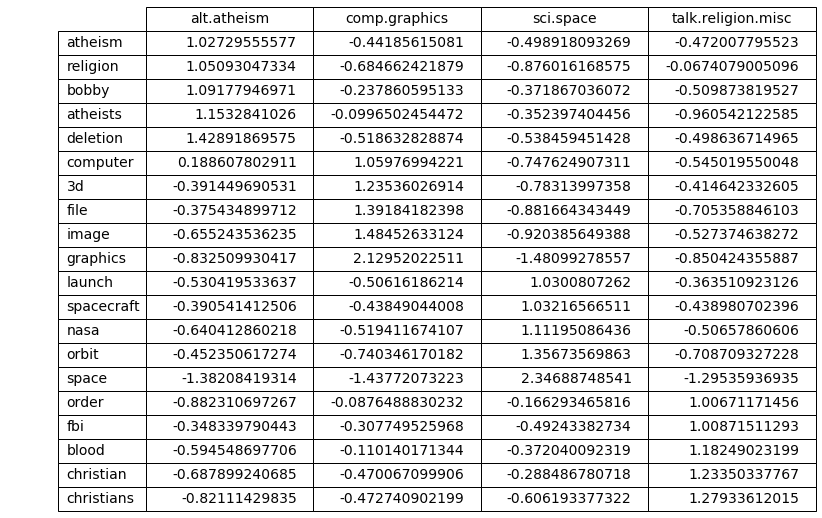



				############ Bigram features weight table ###############



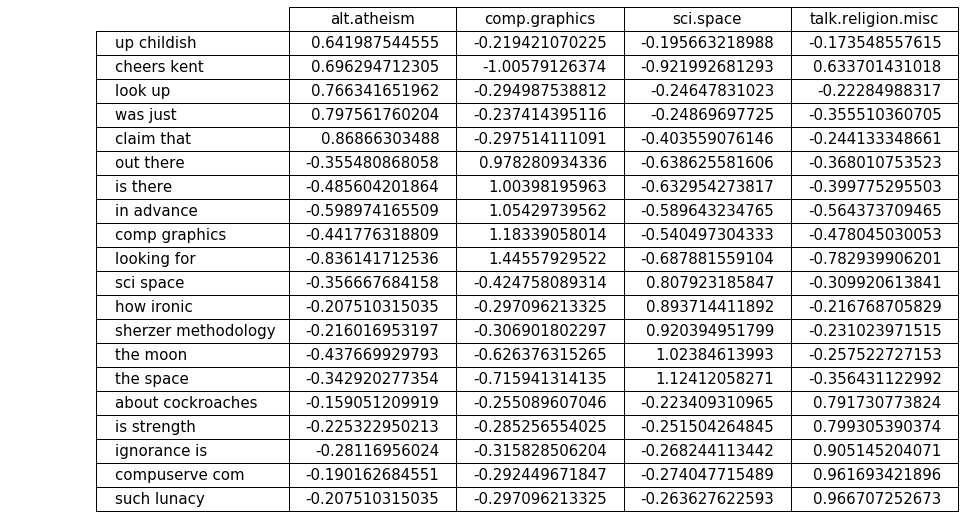

In [6]:
def P4():
### STUDENT START ###
    ##### Unigram 
    num_top_features = 5
    vectorizer = CountVectorizer(min_df=1).fit(train_data)
    X_train_data = vectorizer.transform(train_data)
    X_dev_data = vectorizer.transform(dev_data)
    lr = LogisticRegression(penalty='l2', C=1.5)
    lr.fit(X_train_data, train_labels)
    lr.score(X_dev_data , dev_labels)

    num_classes = len(np.unique(train_labels))
    feature_names = np.array(vectorizer.get_feature_names())
 
    feature_index_unigram = []
    feature_name_unigram = []
# Get top five features for each labels and their indices 
    for j in range(num_classes): 
        for i in range(num_top_features):
            feature_index_unigram.append(vectorizer.vocabulary_.get(feature_names[np.argsort(lr.coef_[j])][-5:][i]))
            feature_name_unigram.append(feature_names[np.argsort(lr.coef_[j])][-5:][i])
    
    
    feature_weight_unigram = np.zeros((len(feature_index_unigram) , num_classes))
# Get weights for top five features for each labels based on their indices
    for j in range(num_classes): 
        for k in range(len(feature_index_unigram)):
            feature_weight_unigram[k, j] = lr.coef_[j] [feature_index_unigram[k]]
   
    
    print '\n\n\t\t\t############ Unigram features weight table ###############\n'
# Using Matplotlib table display weights for each of these fetaures for each of the lables
    fig_unigram, axs_unigram =plt.subplots(1,1)
    collabel_unigram=(newsgroups_train.target_names[0:4])
    rowlabel_unigram=(feature_name_unigram[:])
    axs_unigram.axis('off')
    the_table_unigram = axs_unigram.table(cellText=feature_weight_unigram,colLabels=collabel_unigram,rowLabels=rowlabel_unigram, loc='center')
    the_table_unigram.set_fontsize(22)
    the_table_unigram.scale(2.0, 2.0) 
    plt.show()
    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.3, bottom=0.3)
    plt.show()
    
    ######## Bigram
    
    vectorizer_bigram = CountVectorizer(min_df=1, ngram_range=(2, 2)).fit(train_data)
    X_train_data_bigram = vectorizer_bigram.transform(train_data)
    X_dev_data_bigram = vectorizer_bigram.transform(dev_data)
    lr_bigram = LogisticRegression(penalty='l2', C=1.5)
    lr_bigram.fit(X_train_data_bigram, train_labels)
    lr_bigram.score(X_dev_data_bigram, dev_labels)
    
    feature_names_bigram = np.array(vectorizer_bigram.get_feature_names())

    feature_index_bigram = []
    feature_name_bigram = []
# Get top five features for each labels and their indices 
    for j in range(num_classes): 
        for i in range(num_top_features):
            feature_index_bigram.append(vectorizer_bigram.vocabulary_.get(feature_names_bigram[np.argsort(lr_bigram.coef_[j])][-5:][i]))
            feature_name_bigram.append(feature_names_bigram[np.argsort(lr_bigram.coef_[j])][-5:][i])
# Get weights for top five features for each labels based on their indices   
    feature_weight_bigram = np.zeros((len(feature_index_bigram) , num_classes))
    for j in range(num_classes): 
        for k in range(len(feature_index_bigram)):
            feature_weight_bigram[k, j] = lr_bigram.coef_[j] [feature_index_bigram[k]]
    
    
    print '\n\n\t\t\t\t############ Bigram features weight table ###############\n'
# Using Matplotlib table display weights for each of these fetaures for each of the lables
    fig_bigram, axs_bigram =plt.subplots(1,1)
    collabel_bigram=(newsgroups_train.target_names[0:4])
    rowlabel_bigram=(feature_name_bigram[:])
    axs_bigram.axis('off')
    the_table_bigram = axs_bigram.table(cellText=feature_weight_bigram,colLabels=collabel_bigram,rowLabels=rowlabel_bigram, loc='center')
    the_table_bigram.set_fontsize(22)
    the_table_bigram.scale(2.0, 2.0) 
    plt.show()

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.3, bottom=0.3)
    plt.show()
    
    
### STUDENT END ###
P4()

ANSWER: Many surprising features, which don't seem to be relevant to the category, especially in bigrams such as "cheers kent" in category "alt.atheism", "about cockroaches" in category "talk.religion.misc" and "out there", "is there", "looking for" in the category "comp.graphics".

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [7]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    #lowercase everything
    s = re.sub('[\W]+', ' ', s.lower()) 
    # remove words smaller than 4 characters
    s = re.sub(r'\W*\b\w{1,4}\b', '', s)
    # remove non alpha-numeric characters
    s =  re.sub('[^a-zA-Z0-9 -]', '', s )
    # shorten words with more than 2050 characters
    s =  re.sub('(?<=.{2050})(.*)', '\1', s )
    return s

### STUDENT END ###
def P5():
### STUDENT START ###
    print('\n************************* With empty_preprocessor *****************************')
    # Initialize CountVectorizer with empty_preprocessor
    vectorizer = CountVectorizer(min_df=1, preprocessor=empty_preprocessor).fit(train_data)
    orig_dict_size = len(vectorizer.vocabulary_)
    print("Size of the original vocabulary: {}".format(orig_dict_size) )
    X_train_data = vectorizer.transform(train_data)
    X_dev_data = vectorizer.transform(dev_data)
    lr = LogisticRegression(penalty='l2', C=1.5)
    lr.fit(X_train_data, train_labels)
    yfit = lr.predict(X_dev_data)
    orig_f1_score = metrics.f1_score(dev_labels, yfit, average='weighted' )
    print("For LogisticRegression, F1 score for un-processed data: %3.4f"  %orig_f1_score)
    
    print('\n\n************************* With better_preprocessor *****************************')
    # Initialize CountVectorizer with better_preprocessor
    vectorizer_processed = CountVectorizer(min_df=1, preprocessor=better_preprocessor).fit(train_data)
    preprocessed_dict_size = len(vectorizer_processed.vocabulary_)
    print("Size of the preprocessed vocabulary: {}".format(preprocessed_dict_size) )
   
    
    X_train_data_processed = vectorizer_processed.transform(train_data)
    X_dev_data_processed = vectorizer_processed.transform(dev_data)
    
    
    lr_processed = LogisticRegression(penalty='l2', C=1.5)
    lr_processed.fit(X_train_data_processed, train_labels)
    yfit_processed = lr_processed.predict(X_dev_data_processed)
    preprocssed_f1_score = metrics.f1_score(dev_labels, yfit_processed, average='weighted' )
    print("For LogisticRegression, F1 score for processed data: %3.4f"  %preprocssed_f1_score)
    
    print('\n\n************************* Improvements with better_preprocessor *****************************')
    print("With new preprocessor, reduction in the size of dictionary: {}".format( orig_dict_size - preprocessed_dict_size ) )
    print("With new preprocessor, increase in the f1 score: %3.2f \n" % (float(preprocssed_f1_score - orig_f1_score ) *100 ) ) 
   
   

    
### STUDENT END ###
P5()


************************* With empty_preprocessor *****************************
Size of the original vocabulary: 33291
For LogisticRegression, F1 score for un-processed data: 0.6950


************************* With better_preprocessor *****************************
Size of the preprocessed vocabulary: 16943
For LogisticRegression, F1 score for processed data: 0.7190


************************* Improvements with better_preprocessor *****************************
With new preprocessor, reduction in the size of dictionary: 16348
With new preprocessor, increase in the f1 score: 2.41 



(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]


Size of the original vocabulary: 26879


************For L2 regularization **********************
LogisticRegression accuracy Score for dev data with L2: 0.6997
Non zero features : 26879 for C value: 1.0


************For L1 regularization **********************
Non zero features: 2 for C value: 0.0010 
Non zero features: 17 for C value: 0.0100 
Non zero features: 121 for C value: 0.0500 
Non zero features: 213 for C value: 0.1000 
Non zero features: 438 for C value: 0.2500 
Non zero features: 718 for C value: 0.5000 
Non zero features: 1047 for C value: 1.0000 
Non zero features: 1965 for C value: 5.0000 
Non zero features: 3157 for C value: 10.0000 
Non zero features: 5824 for C value: 50.0000 
Non zero features: 7804 for C value: 100.0000 
Non zero features: 11001 for C value: 200.0000 


**********For L2 regularization with L1 non zero Features ********************
For number of features: 2, accuracy score 0.37, F1 score: 0.32
For number of features: 17, accuracy score 0.48, F1 sc

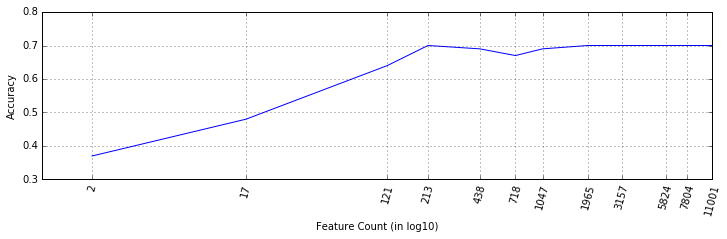

In [8]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    #### CountVectorizer for train data #######
    vectorizer = CountVectorizer(min_df=1).fit(train_data)
    print("\nSize of the original vocabulary: {}".format(len(vectorizer.vocabulary_)) )
    X_train_data = vectorizer.transform(train_data)
    X_dev_data = vectorizer.transform(dev_data)

    #### LogisticRegression with L2 regularization ########
    lr_2 = LogisticRegression(penalty='l2', C=1.0)
    lr_2.fit(X_train_data, train_labels)
    yfit = lr_2.predict(X_dev_data)
    print '\n\n************For L2 regularization **********************'
    print 'LogisticRegression accuracy Score for dev data with L2: %3.4f' %lr_2.score(X_dev_data , dev_labels)

    # Get number of classes
    num_classes = len(np.unique(train_labels))
    non_zero_features_l2 = 0
    # Loop over all the coefficients and see if there are any non zero weights
    for i in range(lr_2.coef_.shape[1]):
        if sum(lr_2.coef_[:,i]) != 0.0:
            non_zero_features_l2 += 1
    print 'Non zero features : %d for C value: 1.0' %non_zero_features_l2 


    c_values_list = [ 0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 200.0]
    non_zero_features_l1_list= []
    l2_accuracy_list = []
    l2_f1_list = []
    print '\n\n************For L1 regularization **********************'
    for i in range(len(c_values_list)):
        lr_1 = LogisticRegression(penalty='l1', C=c_values_list[i], tol = 0.01)
        lr_1.fit(X_train_data, train_labels)
        yfit = lr_1.predict(X_dev_data)
        l1_vocabulary = []
        feature_names = vectorizer.get_feature_names( )
        non_zero_features_l1 = 0
         # Loop over all the coefficients and see if there are any non zero weights
        for j in range(lr_1.coef_.shape[1]):
            if sum(lr_1.coef_[:,j]) != 0.0:
                non_zero_features_l1 += 1
                l1_vocabulary.append(feature_names[j])
        # Get features for non zero weights
        non_zero_features_l1_list.append(non_zero_features_l1)
        print 'Non zero features: %d for C value: %3.4f ' %( non_zero_features_l1, c_values_list[i] )
        # Initialize CountVectorizer with non zero weight features from L1 regularization
        vectorizer_updated = CountVectorizer(min_df=1, vocabulary =l1_vocabulary )
        X_train_data_updated = vectorizer_updated.fit_transform(train_data)
        X_dev_data_updated = vectorizer_updated.transform(dev_data)
        # Run Logistic Regression for vectorizer for non zero weight features only
        lr_2_2 = LogisticRegression(penalty='l2', C=1.0)
        lr_2_2.fit(X_train_data_updated, train_labels)
        yfit_2_2 = lr_2_2.predict(X_dev_data_updated)
        l2_accuracy_list.append(round(lr_2_2.score(X_dev_data_updated , dev_labels), 2))
        l2_f1_list.append(round(metrics.f1_score(dev_labels, yfit_2_2, average='weighted' ), 2))
    
    print '\n\n**********For L2 regularization with L1 non zero Features ********************'
    for k in range(len(non_zero_features_l1_list)):
        print 'For number of features: %d, accuracy score %3.2f, F1 score: %3.2f' %(non_zero_features_l1_list[k], l2_accuracy_list[k], l2_f1_list[k] )
    
    print '\n\n*************************************************************************************************'
    plt.figure(figsize=(12, 3), dpi=160)
    plt.subplot(1, 1, 1)
    plt.plot(np.log10(non_zero_features_l1_list), l2_accuracy_list)
    plt.ylim(0.3, 0.8)
    plt.xlim(0, np.log10(10000))
    plt.ylabel('Accuracy')
    plt.xlabel('Feature Count (in log10)')
    plt.xticks(np.log10(non_zero_features_l1_list), non_zero_features_l1_list, rotation=75)
    plt.grid(True)
    plt.show()
    
    
    

    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [9]:
def P7():
    ### STUDENT START ###
    tfidvectorizer = TfidfVectorizer(min_df=1).fit(train_data)
    print("\nSize of the vocabulary: {}".format(len(tfidvectorizer.vocabulary_)) )
    X_train_data_tfid = tfidvectorizer.transform(train_data)
    X_dev_data_tfid = tfidvectorizer.transform(dev_data)
    lr_7 = LogisticRegression(penalty='l2', C=100)
    lr_7.fit(X_train_data_tfid, train_labels)
    yfit = lr_7.predict(X_dev_data_tfid)
    print 'LogisticRegression accuracy Score for dev data: %3.4f' %lr_7.score(X_dev_data_tfid , dev_labels)

    # Get probability estamtes for dev_data
    posteriors = lr_7.predict_proba(X_dev_data_tfid)
    max_posterior = np.zeros([posteriors.shape[0]])
    predicted_proba_correct_label = np.zeros([posteriors.shape[0]])
    # Get max probability
    for i in range(posteriors.shape[0]):
        max_posterior[i] = np.max(posteriors[i])
    # Get correct labels and its probability
    for i in range(posteriors.shape[0]):
        predicted_proba_correct_label[i] =  posteriors[i, dev_labels[i]]
    # Get R ratio
    top_3_R_doc_index = np.argsort(max_posterior * 1.0/predicted_proba_correct_label) [-3:]
    #print top_3_R_doc_index
    print '\n\n\t\t\t\t Top 3 Documents\n'
    num_R_doc = len(top_3_R_doc_index)
    for i in range(len(top_3_R_doc_index)):

        print("##############################################################################")
        print '\nindex', top_3_R_doc_index[(num_R_doc-1) - i]
        print '\nMax posterior', max_posterior[top_3_R_doc_index[(num_R_doc-1) - i]]
        print '\nPredicted proba of correct label', predicted_proba_correct_label[top_3_R_doc_index[(num_R_doc-1) - i]]
        print '\nR ratio: %3.2f' %np.sort(max_posterior * 1.0/predicted_proba_correct_label) [-3:] [::-1][i]
        print("\nCorrect label: %s  " % (dev_labels[top_3_R_doc_index[(num_R_doc-1) - i]]))
        print("Predicted label: %s \n " % (yfit[top_3_R_doc_index[(num_R_doc-1) - i]]))
        print("\nDev document %d text: \n  %s \n " % (i+1, dev_data[top_3_R_doc_index[(num_R_doc-1) - i]]))
        
    print("##########################################################################################################")

    num_classes = len(np.unique(train_labels))
    num_top_features = 5
    top_features = np.chararray((num_classes , num_top_features), itemsize= 30)
    for j in range(num_classes): 
        for i in range(num_top_features):
            #print 'class: %d, %s' %(j, np.array(tfidvectorizer.get_feature_names())[np.argsort(lr_7.coef_[j])][-5:][i])
            top_features[j, i] = np.array(tfidvectorizer.get_feature_names())[np.argsort(lr_7.coef_[j])][-num_top_features:][i]
    for j in range(num_classes):
        print '\nFor class: %s ,top_features are: %10s' %(newsgroups_train.target_names[j], top_features[j][::-1])
    print("\n##########################################################################################################")
    ### STUDENT END ###
P7()
#[0] --> alt.atheism
#[1] -->comp.graphics
#[2] -->sci.space
#[3] --> talk.religion.misc


Size of the vocabulary: 26879
LogisticRegression accuracy Score for dev data: 0.7633


				 Top 3 Documents

##############################################################################

index 215

Max posterior 0.993719006661

Predicted proba of correct label 0.00106925385355

R ratio: 929.36

Correct label: 3  
Predicted label: 1 
 

Dev document 1 text: 
  I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is 

Use the TfidfVectorizer -- how is this different from the CountVectorizer?
<br>Answer: TfidfVectorizer adds TfidfTransformer to CountVectorizer.
TfidfTransformer does tf-idf transformation, which gives high weight to terms that appear often in a particular document but not in many documents.
<br><br>
What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.
<br>Answer:
By analyzing top 3 documents with the greatest R ratio and looking at the most influential features for each category, it seems that training vocabulary lacks features related to certain specific religion such as Mormon for the category “talk.religion.misc”. Furthermore, model performance exacerbates due to the presence of certain words in these documents such as  ‘file’, ‘internet’, ‘ftp’ which are some of the top features for the other category ‘comp.graphics’.

Additionally, model doesn't differentiate weights for different words based on their position such as words in the title should carry more weights along with bolded and highlighted words.
<br>I suggest :
1. Adding functionality that gives more weightage to the position of the words say in title or highlighted words say in  bold or with header tags.
2. Adding and diversifying training examples to make model aware of certain rare features.



(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

ANSWER: As mentioned in the error analysis in the q7 above, the bag of words destroys inner strucuture of the document by treating each word equally without regards for their postion in the document.
The approach in the question is based on increasing the frequency and in effect, weights of certain percent of words that appear earlier in the document. 
The idea is that words that appear earlier in the document contain title and other imprtant words that descibe the document better than the words that appear later and should carry more weight in categorizing the documents.
Steps:
1. Get the certain percent of intial words in the document.
2. Append these words again to the document by number of times as defined by weight paramter.
3. Using analyzer='char_wb' with ngram_range preserve some local poistioning information.

This approach is able to improve the performance by over 1.3 % (from 76.33% in the q7 with same parameters to 77.66% with 20% of the intial words appended to the document once.)

The approach is somewhat naive and can be improved by using custom vectorizer which takes care of positional information along with certain tags such as bold or header of the words in making estimation for their weights. 

In [10]:
def addWeightforTitle(train_data, percent =10, weight=1):
    num_examples = len(train_data)
    #Create copy of passed data so as not to modify the source data
    train_data_updated = train_data[:]
    # Go over all the documents
    for i in range(num_examples):
        # Get supplied percentage of words for each document
        first_tenper_words = int( (len(train_data_updated[i]) * percent) / 100.0)
        # Encode it to 'ascii'
        train_data_updated[i] = train_data_updated[i].encode('ascii', 'ignore').decode('ascii')
        # Get supplied percentage of words for each document and append it to the document as many times as the parameter weight
        train_data_updated[i] = train_data_updated[i] + ' ' + ( ' '.join(str(train_data_updated[i]).split()[0:first_tenper_words] *weight))
    return train_data_updated

In [11]:
def P8():
    ### STUDENT START ###
    percent = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
    weight =  [1, 2, 3]
    print'\n******************* Logistic Regression using L2 regularization and C=100 for dev data *********************'
    # loop over lists: percent and weight
    for i in range(len(percent)):
        for j in range(len(weight)):
            # Get updated train and dev data
            train_data_updated = addWeightforTitle(train_data, percent =percent[i], weight=weight[j] )
            dev_data_updated = addWeightforTitle(dev_data, percent =percent[i], weight=weight[j])
            # Initilize TfidfVectorizer with analyzer='char_wb' to somewhat preserve local poistioning
            tfidvectorizer = TfidfVectorizer(analyzer='char_wb', min_df=1, ngram_range=(1, 7)).fit(train_data)
            X_train_data_tfid = tfidvectorizer.transform(train_data_updated)
            X_dev_data_tfid = tfidvectorizer.transform(dev_data_updated)
            lr_7 = LogisticRegression(penalty='l2', C=100)
            lr_7.fit(X_train_data_tfid, train_labels)
            yfit = lr_7.predict(X_dev_data_tfid)
            print('\n\tAccuracy Score: %3.4f for the percent of initial text added=%3.2f%% to the document for %d time' % (lr_7.score(X_dev_data_tfid , dev_labels), (percent[i]), weight[j]) )

P8()



******************* Logistic Regression using L2 regularization and C=100 for dev data *********************

	Accuracy Score: 0.7633 for the percent of initial text added=10.00% to the document for 1 time

	Accuracy Score: 0.7692 for the percent of initial text added=10.00% to the document for 2 time

	Accuracy Score: 0.7544 for the percent of initial text added=10.00% to the document for 3 time

	Accuracy Score: 0.7618 for the percent of initial text added=11.00% to the document for 1 time

	Accuracy Score: 0.7648 for the percent of initial text added=11.00% to the document for 2 time

	Accuracy Score: 0.7604 for the percent of initial text added=11.00% to the document for 3 time

	Accuracy Score: 0.7737 for the percent of initial text added=12.00% to the document for 1 time

	Accuracy Score: 0.7589 for the percent of initial text added=12.00% to the document for 2 time

	Accuracy Score: 0.7544 for the percent of initial text added=12.00% to the document for 3 time

	Accuracy Score: